<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-базовая-предобработка-данных" data-toc-modified-id="Загрузка-и-базовая-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и базовая предобработка данных</a></span></li><li><span><a href="#Разведочный-анализ-данных" data-toc-modified-id="Разведочный-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разведочный анализ данных</a></span></li><li><span><a href="#Базовая-(BaseLine)-модель" data-toc-modified-id="Базовая-(BaseLine)-модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Базовая (BaseLine) модель</a></span></li><li><span><a href="#Подбор-оптимальных-гиперпараметров" data-toc-modified-id="Подбор-оптимальных-гиперпараметров-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подбор оптимальных гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#Логистическая-Регрессия" data-toc-modified-id="Логистическая-Регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая Регрессия</a></span></li><li><span><a href="#Naiive-Bayes-Classifier" data-toc-modified-id="Naiive-Bayes-Classifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Naiive Bayes Classifier</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#XG-Boost" data-toc-modified-id="XG-Boost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>XG-Boost</a></span></li><li><span><a href="#LG-Boost" data-toc-modified-id="LG-Boost-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>LG-Boost</a></span></li><li><span><a href="#Финальное-сравнение-и-выбор-алгоритма" data-toc-modified-id="Финальное-сравнение-и-выбор-алгоритма-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Финальное сравнение и выбор алгоритма</a></span></li></ul></li><li><span><a href="#Обучение-финальной-модели" data-toc-modified-id="Обучение-финальной-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение финальной модели</a></span></li><li><span><a href="#Генерация-прогноза-по-ТЕСТОВОЙ-выборке" data-toc-modified-id="Генерация-прогноза-по-ТЕСТОВОЙ-выборке-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Генерация прогноза по ТЕСТОВОЙ выборке</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import datetime
import calendar
import scipy as sc
from pprint import pprint
import pickle

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as SM_Pipeline
import itertools

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import make_scorer


%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(37)

### Загрузка и базовая предобработка данных

In [2]:
# 1.1. Загрузка сырых данных
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
# data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')
data_feat = pd.read_csv('../feat_data/features.csv', encoding='utf-8', sep='\t') # файл - вне GIT папки

**Предварительные исследования данных, выводы:**

Ниже представлены выводы на основе базового изучения загруженных данных, исходный код представляет собой точечные проверки и не приведен.


- пользователи (id)
  - на тренировочной выборке кол-во пользователей и предложений близки: 806613 и 831653, что говорит о малом количестве пользователей, которым предлагались пакета 2 или более раз
  - на тестовой выборке ситуация аналогичная: 71231 и 70152
  - число общих для тренировочной и тестовой выборок пользователей (пересечение) мало - 4188
  - таким образом номера пользователей, как таковые, не могут самостоятельно быть использованы в качестве признака
  - вместе с тем, число уникальных пользователей в данных `data_feat` - составляет около 4,4 млн. и покрывает и train, и test выборки, а также содержит избыточную информацию по другим пользователям


- пустые значения (пропуски)
  - не обнаружены, для экономии времени, в соответствующих pipelines такая проверка осуществляться не будет


- buy_time
  - даты на тренировочных и тестовых данных - не пересекаются
  - во всех данных - время идентично (3 часа утра)
  - во всех данных - день недели идентичен (Понедельник)
  - таким образом, считаю, что использование данных тренировочной выборки не несет пользы для тестовой и соответствующие данные не будут использованы в качестве признака
  

- добавление признаков
  - с учетом предыдущего пункта, предлагается преобразовать train and test выборки путем добавления анонимизированных признаков, соответствующих id
  - при этом будет осуществлена группировка значений признаков по id с агрегационными функциями median
  - идентификация типа признаков на categorical и numerical в данном случае осуществляться не будет в виду малого количества локальных срезов на одного пользователя (в данном случае most_frequent может давать множественные значения), и будет использоваться на следующих этапах
  - сами признаки id в дальнейшем будут удалены

In [3]:
# 1.2. Функция преобработки признаков
def create_X_y(main_data, feat_data, agg_func='median', user_col='id', target_col='target'):
    try:
        if target_col in main_data.columns:
            X = main_data.drop(columns=[target_col, 'Unnamed: 0'], axis=1)
            y = main_data[target_col]
        else:
            X = main_data.drop(columns=['Unnamed: 0'], axis=1)
            
        X_users = list(set(X.id.tolist()))
        feat_data_sliced = feat_data.loc[feat_data[user_col].isin(X_users)]
        feat_data_sliced = feat_data_sliced.drop(columns=['buy_time', 'Unnamed: 0'], axis=1)
        feat_data_sliced = feat_data_sliced.groupby(user_col).aggregate(agg_func)
            
        X = pd.merge(X, feat_data_sliced, on=[user_col])
        X = X.drop(columns=[user_col, 'buy_time'], axis=1)
        
        if target_col in main_data.columns:
            return X, y
        else:
            return X
            
    except Exception as e:
        print('operation unsuccefull:', e)      

In [4]:
# 1.3. Предобработка признаков
X_train, y_train = create_X_y(data_train, data_feat)
#X_test = create_X_y(data_test, data_feat) # delete in final version
data_feat = None

In [5]:
# 1.4. Генерация списков признаков по типам (числовые, категориальные). Функция
def create_col_type_lists(X_train=X_train, cat_max=10):
    val_dict = X_train.nunique().to_dict()
    result = dict.fromkeys(['const', 'cat', 'num'])
    f_all = set(val_dict.keys())
    result['const'] = set({k:v for (k,v) in val_dict.items()  if v==1}.keys())
    result['cat'] = set({k:v for (k,v) in val_dict.items()  if v <= cat_max and v>1}.keys())
    result['num'] = f_all - result['const'] - result['cat']
        
    return list(result['num']), list(result['cat']), list(result['const'])

In [6]:
F_NUM, F_CAT, F_CONST = create_col_type_lists()
print(f'итого категориальных признаков: {len(F_CAT)}, числовых: {len(F_NUM)}')

итого категориальных признаков: 27, числовых: 222


### Разведочный анализ данных

В данном случае EDA будет ограничена только анализом X_train и y_train и следующими аспектами:
- визуальный анализ целевой переменной
- корелляционный анализ
- PCA
- изучение наличия кластеров (Kmeans)

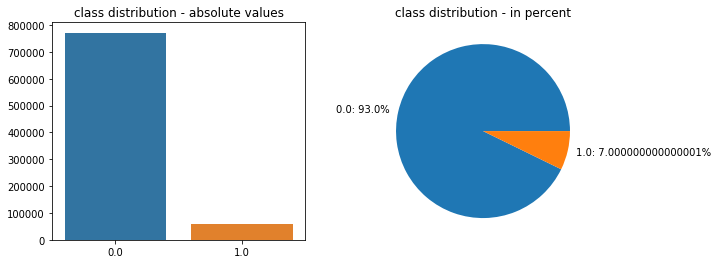

class values


0.0    771467
1.0     60186
Name: target, dtype: int64

In [7]:
# 2.1. Визуальный анализ целевой переменной
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title('class distribution - absolute values')
ax[1].set_title('class distribution - in percent')
sns.barplot(list(y_train.value_counts().index), list(y_train.value_counts()), ax=ax[0])
labels_percent = [f'{i}: {round(j/len(y_train),2)*100}%' for i,j 
                  in zip(y_train.value_counts().index, y_train.value_counts())]
ax[1].pie(list(y_train.value_counts()/len(y_train)), labels=labels_percent)
plt.show()

print('class values')
display(y_train.value_counts())

Как видно, имеется дисбаланс классов, поэтому в обучении будет применен resampling

In [8]:
# 2.2. Подготовка данных для EDA-анализа

X_train_eda = X_train.drop(columns=F_CONST, axis=1)
X_train_eda[F_CAT] = X_train_eda[F_CAT].astype('category')
X_train_eda = pd.get_dummies(X_train_eda, prefix='cat', drop_first=False)
col_names = X_train_eda.columns
X_train_eda = pd.DataFrame(MinMaxScaler().fit_transform(X_train_eda), columns=col_names)
X_train_eda.describe()

,0,1,2,3,4,5,6,7,8,9,...,cat_1.9999166764172984,cat_44.99991667641729,cat_249.99991667641729,cat_-4.033215971180677e-05,cat_0.9999596678402882,cat_1.4999596678402882,cat_1.999959667840288,cat_2.9999596678402884,cat_3.999959667840288,cat_7.999959667840288
count,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,0.005412,0.006773,0.012372,0.006939,0.012375,0.006986,0.002551,0.003765,0.004384,0.008599,...,0.000001,0.000001,0.000001,0.999990,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001
std,0.001404,0.002157,0.001425,0.002465,0.001478,0.002734,0.001190,0.001665,0.001312,0.002213,...,0.001097,0.001097,0.001097,0.003102,0.001899,0.001097,0.001097,0.001097,0.001097,0.001097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004956,0.005795,0.011854,0.005806,0.011833,0.005775,0.002474,0.003455,0.004307,0.008259,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.005016,0.006489,0.011979,0.006567,0.011971,0.006548,0.002474,0.003455,0.004307,0.008259,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005476,0.007326,0.012505,0.007527,0.012515,0.007542,0.002474,0.003483,0.004307,0.008259,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


число пар с высокой корелляцией = 138.0


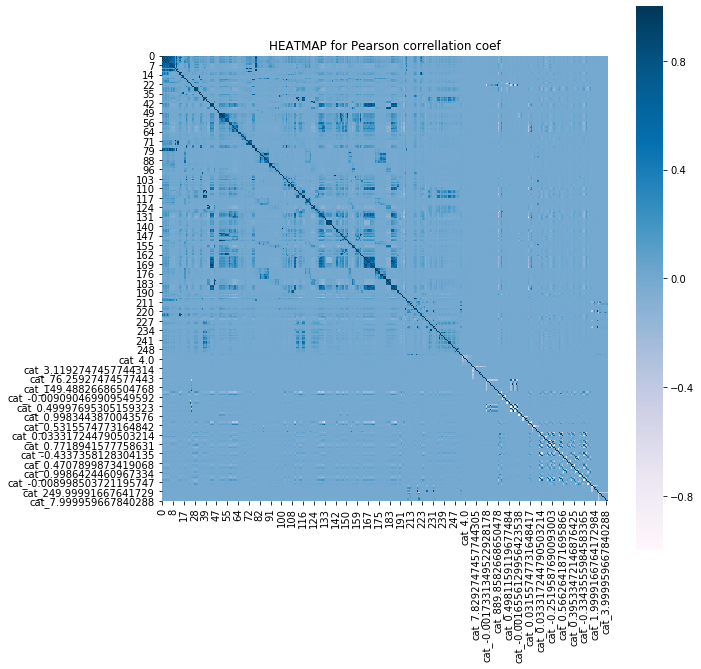

In [9]:
# 2.3. Корелляционный анализ

# 2.3.1. Функция heatmap
def plot_corr_map(corr_matrix):
    "plot given correlation matrix in heatmap style"
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    ax.set_title('HEATMAP for Pearson correllation coef')
    sns.heatmap(corr_matrix, square=True,ax=ax,cmap='PuBu');

# 2.3.2. Расчет корелляционной матрицы
corr_matrix = X_train_eda.corr()

# 2.3.3. Визуализация корелляционной матрицы
plot_corr_map(corr_matrix)

# 2.3.4. Расчет высококореллированных значений
correlated_features = dict()
corr_threshold = 0.8

for col in corr_matrix.columns:
    for row in corr_matrix[col].index:
        if corr_threshold < abs(corr_matrix.loc[row, col]) < 1.0:
            pair = f'{row}-{col}'
            correlated_features[pair] = corr_matrix.loc[row, col]

print(f'число пар с высокой корелляцией = {len(correlated_features)/2}')

Как видно, существует достаточно много высококореллированных пар, поэтому на следующих этапах может понадобиться отсечение или преобразование признаков. С другой стороны это отчасти происходит из-за того, что при кодировании категориальных данных не отбрасывались стартовые категории.

In [10]:
# 2.4. Анализ PCA

break_even = [0.8, 0.9, 0.95, 0.975, 0.99]

pca = PCA()
X_train_pca = pca.fit_transform(X_train_eda)
var_vector = np.cumsum(pca.explained_variance_ratio_)

for level in break_even:
    temp_list = []
    for n in var_vector:
        if n<=level: temp_list.append(n)
    print(f'required number of components for {level*100}% of total VAR is {len(temp_list)}')

required number of components for 80.0% of total VAR is 13
required number of components for 90.0% of total VAR is 21
required number of components for 95.0% of total VAR is 28
required number of components for 97.5% of total VAR is 36
required number of components for 99.0% of total VAR is 45


Как видно, 45 производных РСА-переменных могут охватить 99% вариации и при этом существенно снизить расчетную нагрузку

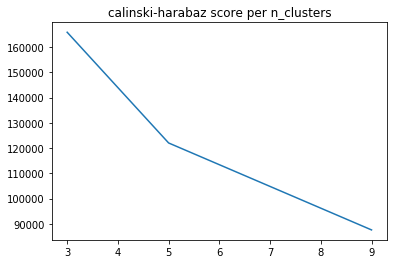

In [13]:
# 2.4. KMeans++

# 2.4.1. Подбор параметра 
# Данный анализ занимает ~15-20 мин


n_cluster_list, calinski_metric_list = [], []

for n_cluster in [3, 5, 9]:
    n_cluster_list.append(n_cluster)
    k_means = KMeans(n_clusters=n_cluster, random_state=42, init='k-means++', n_jobs=-1)
    k_means.fit(X_train_eda)
    calinski_metric_list.append(calinski_harabaz_score(X_train_eda, k_means.labels_))
    
fig = plt.Figure(figsize=(14,4))
plt.title('calinski-harabaz score per n_clusters')
plt.plot(n_cluster_list, calinski_metric_list)
plt.show()

Оптимальное количество кластеров - 3

### Базовая (BaseLine) модель

In [18]:
# 3.1. Класс кодировки категориальных данных

class Encoder(BaseEstimator, TransformerMixin):
    """
    специальный класс-трансформер, который определяет и преобразует категориальные данные
    в dummy-признаки, при этом использует метод `pd.get_dummies` вместо `OneHotEncoder` и
    возвращает результат в DataFrame вместо Sparse Matrix
    ---------------------------------------------------------------------------------------------
    параметры инициализации:
    - `drop_first` (=True, BOOL) - удаляет первый dummy-признак в рамках одной категории
    - `cat_max` (=10, INT) - устанавливает максимальное число значений признака для ее перевода 
    в категориальный признак
    - `verbose (=False, BOOL)` - выводит имена dummy-переменных, которые отсутствуют в данных
    для трансформации, а также выводит имена новых dummy-переменных, отсутствующих на этапе fit
    ---------------------------------------------------------------------------------------------
    данный класс не рекомендуется к использованию в Пайплайнах при Grid_Search
    """
    def __init__(self, drop_first=True, cat_max=10, verbose=False):
        
        self.drop_first = drop_first
        self.cat_max = cat_max
        self.verbose = verbose
        
    def _create_col_type_lists(self, X, cat_max):
        
        val_dict = X.nunique().to_dict()
        result = dict.fromkeys(['const', 'cat', 'num'])
        f_all = set(val_dict.keys())
        result['const'] = set({k:v for (k,v) in val_dict.items()  if v==1}.keys())
        result['cat'] = set({k:v for (k,v) in val_dict.items()  if v <= cat_max and v>1}.keys())
        result['num'] = f_all - result['const'] - result['cat']

        return list(result['num']), list(result['cat']), list(result['const'])
    
    
    def fit(self, X, y=None):
        self.f_num, self.f_cat, self.f_const = self._create_col_type_lists(X, self.cat_max)
        X_train = X.drop(columns=self.f_const, axis=1)
        X_train[self.f_cat] = X_train[self.f_cat].astype('category')
        X_train = pd.get_dummies(X_train, prefix=self.f_cat, drop_first=self.drop_first)
        self.train_cols = X_train.columns
        return self
    
    
    def transform(self, X, y=None):
        X = X.drop(columns=self.f_const, axis=1)
        X[self.f_cat] = X[self.f_cat].astype('category')
        X = pd.get_dummies(X, prefix=self.f_cat, drop_first=self.drop_first)
        lost_cat_cols = list(set(self.train_cols) - set(X.columns))
        new_cat_cols = list(set(X.columns) - set(self.train_cols))
        if self.verbose:
            if len(lost_cat_cols) > 0:
                print(f'categorical dummy-cols with zeroes: {lost_cat_cols}')
            if len(new_cat_cols) > 0:
                print(f'new (ignored and dropped) dummy-cols: {new_cat_cols}')
        if len(lost_cat_cols) > 0:
            for col in lost_cat_cols:
                X[col] = np.zeros(X.shape[0], dtype=int)
        if len(new_cat_cols) > 0:
            X = X.drop(columns=new_cat_cols, axis=1)
                
        return X
        

In [19]:
# 3.2. Добавление категориальных dummy в X_train
cat_encoder = Encoder(drop_first=True, cat_max=10, verbose=True)
cat_encoder.fit(X_train)
X_train_wcat = cat_encoder.transform(X_train)

In [20]:
# 3.2. Небольшая разбивка данных на тренировочную и валидационную выборки 
VALID_PORTION = 0.20
X_train_gs, X_valid, y_train_gs, y_valid = train_test_split(X_train_wcat, y_train, test_size=VALID_PORTION,
                                                           random_state=37)

print(X_train_gs.shape, y_train_gs.shape, X_valid.shape, y_valid.shape)

(665322, 303) (665322,) (166331, 303) (166331,)


**Параметры базовой модели**:

- в качестве базовой модели будет взята Логистическая Регрессия
- при этом сразу будут рассмотрены 2 вариантa:
  - базовый набор данных и l1-регуляризация
  - pca-набор данных (45 компонент) и l2-регуляризация
- для обоих вариантов будет использован солвер SAGA, оптимизированный для больших датасетов
- в качестве метода масштабирования будет взят вариант MinMaxScaler
- в качестве метрики будет выбрана f1_score(macro)
- в качестве метода балансировки классов выбран SMOTE библиотеки imblearn (oversampling)

В дальнейшем, учитывая большие объемы данных и, как следствие, большое расчетное время, реализация подбора гиперпараметров будет вестись на уменьшенном пространстве гиперпараметров. При этом для валидации не будет использоваться GridSearch, т.к. это сложно на ограниченных аппаратных возможностях. Подобные ограничения не 
гарантируют получение наилучшего результата и продиктованы только имеющимися условиями реализации Проекта.

In [21]:
# 3.3. Подготовка для запуска базовых моделей

# 3.3.1. Базовые параметры
smote = SMOTE(sampling_strategy='auto', n_jobs=-1)
f1_macro = make_scorer(f1_score, average='macro')

# 3.3.2. Пайплайны для baseline models (LogReg)
pipe_lr_l1_steps = [
    ('scaler', MinMaxScaler()),
    ('oversampler', smote),
    ('logreg', LogisticRegression(penalty='l1', solver='saga', random_state=37, 
                                  class_weight='balanced', n_jobs=-1))
]

pipe_lr_pca_steps = [
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=45)),
    ('oversampler', smote),
    ('logreg', LogisticRegression(penalty='l2', solver='saga', random_state=37, 
                                  class_weight='balanced', n_jobs=-1))
]

pipe_lr_l1 = SM_Pipeline(pipe_lr_l1_steps, verbose=True)
pipe_lr_pca = SM_Pipeline(pipe_lr_pca_steps, verbose=True)

Using TensorFlow backend.


In [22]:
# 3.4. Логистическая регрессия с L1-регуляризацией
pipe_lr_l1.fit(X_train_gs, y_train_gs)
predict = pipe_lr_l1.predict(X_valid)
print(classification_report(y_valid, predict))

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   2.9s
[Pipeline] ....... (step 2 of 3) Processing oversampler, total= 4.3min
[Pipeline] ............ (step 3 of 3) Processing logreg, total= 6.9min
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.78      0.45     12117

    accuracy                           0.86    166331
   macro avg       0.65      0.83      0.69    166331
weighted avg       0.93      0.86      0.89    166331



In [23]:
# 3.5. Логистическая регрессия с L2-регуляризацией и преобразованием признаков в главные компоненты
pipe_lr_pca.fit(X_train_gs, y_train_gs)
predict = pipe_lr_pca.predict(X_valid)
print(classification_report(y_valid, predict))

[Pipeline] ............ (step 1 of 4) Processing scaler, total=   2.9s
[Pipeline] ............... (step 2 of 4) Processing pca, total=  12.1s
[Pipeline] ....... (step 3 of 4) Processing oversampler, total=  21.2s
[Pipeline] ............ (step 4 of 4) Processing logreg, total=  15.0s
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.78      0.45     12117

    accuracy                           0.86    166331
   macro avg       0.65      0.83      0.69    166331
weighted avg       0.93      0.86      0.89    166331



Как видно из результатов, уменьшение пространства признаков существенно сокращает время обучения, не теряя в качестве, поэтому для дальнейших расчетов будет использоваться PCA-преобразование.

Вместе с тем, базовая метрика составляет 0.69, что является удовлетворительным результатом и должно быть улучшено.

### Подбор оптимальных гиперпараметров

**Используемые подходы и алгоритмы**
- рассматриваются следующие алгоритмы
  - Logistic Regression
  - Naiive Bayes Classifier
  - Random Forest
  - XG-Boost
  - Lightgbm
- валидационная метрика - f1-score(average=macro)
- для удобства вызов поиска параметров будет реализован через класс `SingleModel`

- алгоритм подбора гиперпараметров и выбора модели
  - тренировочная выборка разделяется на train_gs (0.8) и valid (0.2) подвыборки
  - осуществляется поиск с KFOLD(3) по сетке гиперпараметров
    - в целях оптимизации повторного запуска кода - я оставил найденные оптимальные параметры в grid ниже
  - найденная оптимальная комбинация гиперпараметров используется для повторного обучения на всей подвыборке train_gs
  - подбирается оптимальное значение вероятности для калибровки модели
  - в обоих этапах (поиск по сетке и повторное обучение) - тренировочные данные преобразуются в след.последовательности:
    - масштабируются с применением MinMaxScaler
    - преобразуются в главные компоненты (n=45)
    - oversampled by SMOTE
  - конечная метрика, параметры и вероятность сохраняются в файле `gs_results.pkl`

In [99]:
cv_3 = KFold(n_splits=3, shuffle=True, random_state=37)
gs_results = dict()

# Класс-обертка для поиска гиперпараметров

class SingleModel:
    
    
    def __init__(self, estimator, model_label='', random_state=37, param_grid={}, cv=cv_3, verbose=True):
        
        self.model_label = model_label
        self.random_state = random_state
        self.param_grid = param_grid
        self.cv = cv
        self.verbose = verbose
        self.n_pca = 45
        self.sampling_strategy = 'auto'
        self.scaler = MinMaxScaler()
        self.estimator = estimator
        self.pca = PCA(n_components=self.n_pca, random_state=self.random_state)
        self.sampler = SMOTE(sampling_strategy=self.sampling_strategy,
                             random_state=self.random_state, n_jobs=-1)
        
        
        
    def _parse_params(self, param_grid):
        param_dict = dict()
        for key, value in param_grid.items():
            param_dict[self.model_label+"__"+key] = value
        return param_dict
        
    
    def set_n_pca(self, n):
        self.n_pca = n
    
    def set_scaler(self, scaler_class):
        self.scaler = scaler_class
        
    def set_sampling_strategy(self, sampling_strategy):
        self.sampling_strategy = sampling_strategy
    
    def run_grid_search(self, X_train_gs, y_train_gs):
        pipe_steps = [
            ('scaler', self.scaler),
            ('pca', self.pca),
            ('oversampler', self.sampler),
            (self.model_label, self.estimator)
        ]
        
        self.pipe = SM_Pipeline(pipe_steps)
        params = self._parse_params(self.param_grid)
        grid = GridSearchCV(estimator=self.pipe, param_grid=params, scoring=f1_macro,
                           n_jobs=-1, cv=self.cv, verbose=self.verbose)
        
        grid.fit(X_train_gs, y_train_gs)
        self.best_model_gs = grid.best_estimator_[-1]
        print(f'best f1 score on CV = {grid.best_score_}')
        self.best_params_gs = self.best_model_gs.get_params()
        print(self.best_params_gs)
        self.gs_results = grid.cv_results_
        
    def _show_proba_calibration_plots(self, y_predicted_probs, y_true_labels, p_min, p_max, p_step):
        y_predicted_probs = y_predicted_probs[:,1]
        preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

        thresholds = []
        precisions = []
        recalls = []
        f1_scores = []

        for threshold in np.linspace(p_min, p_max, p_step):
            thresholds.append(threshold)
            precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
            recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
            f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), average='macro'))

        scores_table = pd.DataFrame({'f1':f1_scores,
                                     'precision':precisions,
                                     'recall':recalls,
                                     'probability':thresholds}).sort_values('f1', ascending=False).round(3)

        figure = plt.figure(figsize = (15, 5))

        plt1 = figure.add_subplot(121)
        plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
        plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
        plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
        plt1.set_ylabel('Scores')
        plt1.set_xlabel('Probability threshold')
        plt1.set_title('Probabilities threshold calibration')
        plt1.legend(bbox_to_anchor=(0.25, 0.25))   
        
        plt2 = figure.add_subplot(122)
        plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
                  label='Another class', color='royalblue', alpha=1)
        plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
                  label='Main class', color='darkcyan', alpha=0.8)
        plt2.set_ylabel('Number of examples')
        plt2.set_xlabel('Probabilities')
        plt2.set_title('Probability histogram')
        plt2.legend(bbox_to_anchor=(1, 1))

        plt.show()
    
    
    def _update_predict_by_prob(self, y_true, predict_probas, prob_min, prob_max, prob_steps, show_chart=False):
        
        prob_range = np.linspace(prob_min, prob_max, prob_steps)
        scores = []
        for p in prob_range:
            predict_rebalanced = np.array([1 if x>=p else 0 for x in predict_probas[:,1]])
            scores.append(f1_score(y_true, predict_rebalanced, average='macro'))
        if show_chart:
            figure = plt.figure(figsize = (5, 4))
            plt.ylabel('Scores')
            plt.xlabel('Probability threshold')
            plt.plot(prob_range, scores, label='f1 macro', linewidth=4)
            plt.title("Best Threshold Probability Search")
            plt.show()
        scores = np.array(scores)
        best_prob = prob_range[scores.argmax()]
        print(f'best threshold probability = {best_prob}')
        predict_rebalanced_final = np.array([1 if x>=best_prob else 0 for x in predict_probas[:,1]])
        
        return predict_rebalanced_final, best_prob 
    
    
    def test_best_model_on_valid_set(self, X_train_gs, y_train_gs, X_valid, y_valid,
                                    prob_min=0.1, prob_max=0.9, prob_steps=30):
        pipe_steps = [
            ('scaler', self.scaler),
            ('pca', self.pca),
            ('oversampler', self.sampler),
            (self.model_label, self.best_model_gs)
        ]
        
        self.pipe_valid = SM_Pipeline(pipe_steps)
        self.pipe_valid.fit(X_train_gs, y_train_gs)
        predict = self.pipe_valid.predict(X_valid)
        print('report before calibration')
        print(classification_report(y_valid, predict))
        
        predict_probas = self.pipe_valid.predict_proba(X_valid)
        self._show_proba_calibration_plots(predict_probas, y_valid, prob_min, prob_max, prob_steps)
        
        predict2, self.threshold_prob = self._update_predict_by_prob(y_valid, predict_probas, prob_min, 
                                                                prob_max, prob_steps, show_chart=True)
        
        print('report after calibration')
        print(classification_report(y_valid, predict2))
        
        print(f'f1 score before calibration {f1_score(y_valid, predict, average="macro")}')
        print(f'f1 score after calibration {f1_score(y_valid, predict2, average="macro")}')
        
        self.f1_macro_final = f1_score(y_valid, predict2, average="macro")

    def add_gs_results(self, result_dict=gs_results):
        
        gs_results_dict = {
            'f1_macro': self.f1_macro_final,
            'best_params': self.best_params_gs,
            'probability': self.threshold_prob
        }
        
        gs_results[self.model_label] = gs_results_dict
              

def save_gs_results(obj=gs_results, name='gs_results'):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_gs_results(name='gs_results.pkl'):
    with open(name, 'rb') as f:
        return pickle.load(f)
              
              


#### Логистическая Регрессия

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


best f1 score on CV = 0.6901426681304033
{'C': 0.0001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 0.1, 'verbose': 0, 'warm_start': False}
report before calibration
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.77      0.46     12117

    accuracy                           0.87    166331
   macro avg       0.65      0.82      0.69    166331
weighted avg       0.93      0.87      0.89    166331



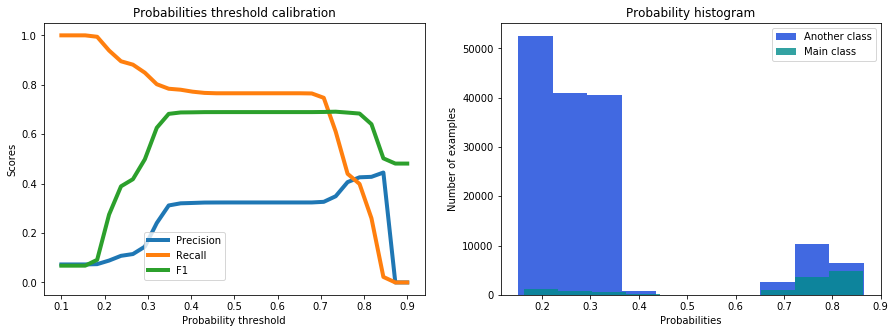

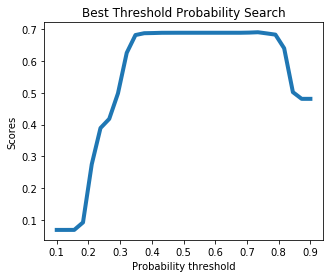

best threshold probability = 0.7344827586206897
report after calibration
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    154214
         1.0       0.35      0.61      0.44     12117

    accuracy                           0.89    166331
   macro avg       0.66      0.76      0.69    166331
weighted avg       0.92      0.89      0.90    166331

f1 score before calibration 0.6894450498088802
f1 score after calibration 0.6910450391905105


In [100]:
lr_estimator = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42, max_iter=200)

param_grid = {
    'solver': ['saga'],
    'penalty': ['l2'],
    'tol': [1e-1],
    'C': [0.0001],
    }

lr_gs = SingleModel(estimator=lr_estimator, model_label='logreg', param_grid=param_grid, cv=cv_3)

lr_gs.run_grid_search(X_train_gs=X_train_gs, y_train_gs=y_train_gs)

lr_gs.test_best_model_on_valid_set(X_train_gs, y_train_gs, X_valid, y_valid)

lr_gs.add_gs_results(gs_results)

In [101]:
save_gs_results()

Как видно, подбор гиперпараметров, как и калибровка вероятностей, не привела с ощутимому (более 1%) увеличению f1.

#### Naiive Bayes Classifier

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


best f1 score on CV = 0.689019708718158
{'priors': None, 'var_smoothing': 1}
report before calibration
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.77      0.45     12117

    accuracy                           0.87    166331
   macro avg       0.65      0.82      0.69    166331
weighted avg       0.93      0.87      0.89    166331



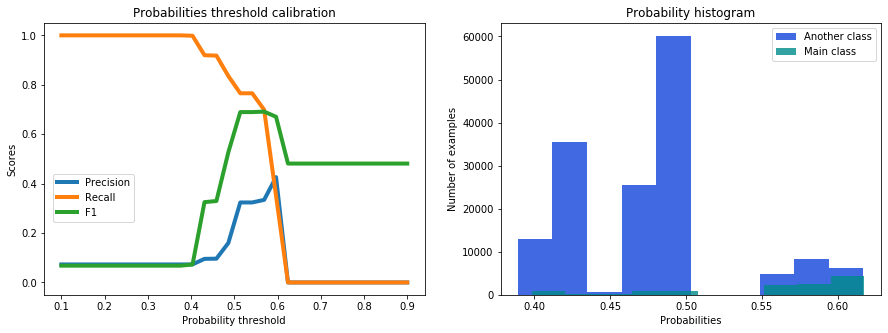

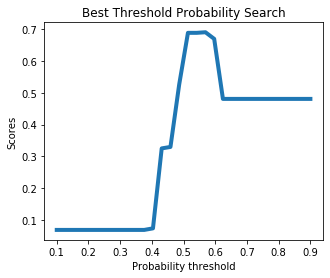

best threshold probability = 0.5689655172413793
report after calibration
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93    154214
         1.0       0.33      0.70      0.45     12117

    accuracy                           0.88    166331
   macro avg       0.65      0.79      0.69    166331
weighted avg       0.93      0.88      0.90    166331

f1 score before calibration 0.6893394185701356
f1 score after calibration 0.6913127527966346


In [102]:
nbc_estimator = GaussianNB()

param_grid = {
    'priors': [None],
    'var_smoothing': [1],
    }

nbc_gs = SingleModel(estimator=nbc_estimator, model_label='bayes', param_grid=param_grid, cv=cv_3)

nbc_gs.run_grid_search(X_train_gs=X_train_gs, y_train_gs=y_train_gs)

nbc_gs.test_best_model_on_valid_set(X_train_gs, y_train_gs, X_valid, y_valid)

nbc_gs.add_gs_results(gs_results)

In [103]:
save_gs_results()

Naive Bayes Classifier - не позволяет достичь более высокого показателя, чем алгоритм Логистической регрессии

#### Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.7min finished


best f1 score on CV = 0.6899432774779469
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 0.03, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
report before calibration
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.77      0.45     12117

    accuracy                           0.87    166331
   macro avg       0.65      0.82      0.69    166331
weighted avg       0.93      0.87      0.89    166331



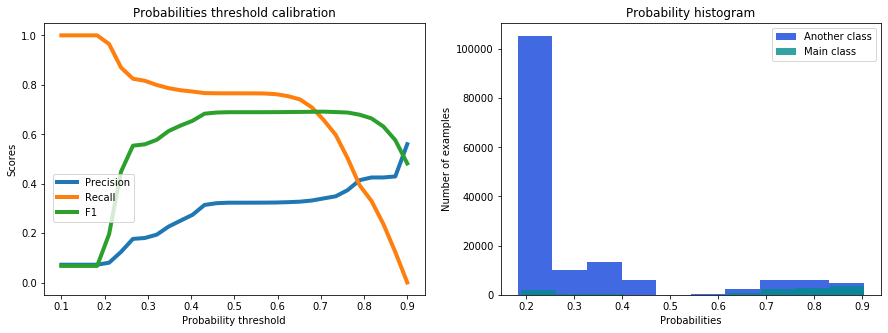

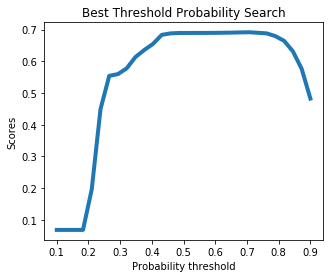

best threshold probability = 0.706896551724138
report after calibration
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93    154214
         1.0       0.34      0.66      0.45     12117

    accuracy                           0.88    166331
   macro avg       0.66      0.78      0.69    166331
weighted avg       0.93      0.88      0.90    166331

f1 score before calibration 0.6893337348956102
f1 score after calibration 0.69160755791672


In [104]:
rf_estimator = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample')

param_grid = {
    'max_depth': [7],
    'min_samples_leaf': [0.03],
    'n_estimators': [200]
    }

rf_gs = SingleModel(estimator=rf_estimator, model_label='random_forest', param_grid=param_grid, cv=cv_3)

rf_gs.run_grid_search(X_train_gs=X_train_gs, y_train_gs=y_train_gs)

rf_gs.test_best_model_on_valid_set(X_train_gs, y_train_gs, X_valid, y_valid)

rf_gs.add_gs_results(gs_results)

In [105]:
save_gs_results()

Алгоритм случайного леса - не позволяет достичь более высокого показателя, чем алгоритм Логистической регрессии

#### XG-Boost

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


best f1 score on CV = 0.6901426681304033
{'base_score': 0.5, 'booster': 'gblinear', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'n_estimator': 100}
report before calibration
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.77      0.46     12117

    accuracy                           0.87    166331
   macro avg       0.65      0.82      0.69    166331
weighted avg       0.93      0.87      0.89    166331



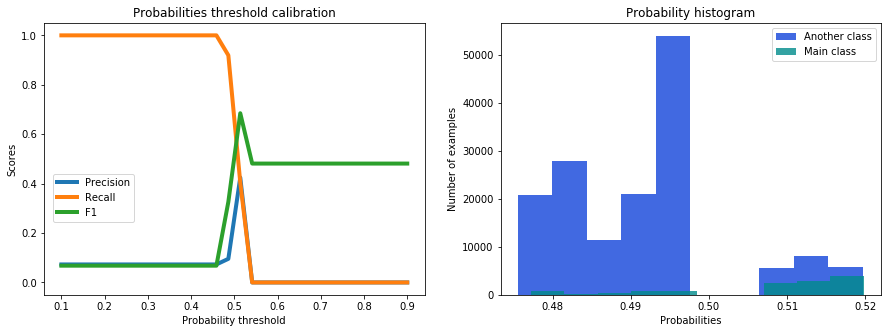

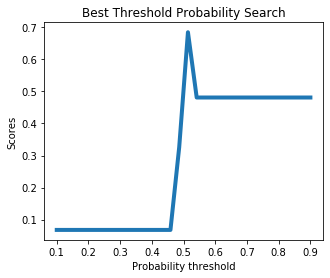

best threshold probability = 0.5137931034482759
report after calibration
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96    154214
         1.0       0.42      0.40      0.41     12117

    accuracy                           0.92    166331
   macro avg       0.69      0.68      0.68    166331
weighted avg       0.91      0.92      0.92    166331

f1 score before calibration 0.6894450498088802
f1 score after calibration 0.6847578204100877


In [106]:
xg_estimator = xgb.XGBClassifier(n_jobs=-1, random_state=42)

param_grid = {
    'n_estimator': [100],
    'learning_rate': [0.1],
    'booster': ['gblinear'],
    'max_depth': [3],
    'reg_lambda': [1],
    'reg_alpha': [0]
    }

xg_gs = SingleModel(estimator=xg_estimator, model_label='xgboost', param_grid=param_grid, cv=cv_3)

xg_gs.run_grid_search(X_train_gs=X_train_gs, y_train_gs=y_train_gs)

xg_gs.test_best_model_on_valid_set(X_train_gs, y_train_gs, X_valid, y_valid)

xg_gs.add_gs_results(gs_results)

In [107]:
save_gs_results()

XGBoost - не позволяет достичь более высокого показателя, чем алгоритм Логистической регрессии

#### LG-Boost

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


best f1 score on CV = 0.6879230902972364
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 120, 'n_jobs': -1, 'num_leaves': 10, 'objective': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
report before calibration
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    154214
         1.0       0.32      0.78      0.45     12117

    accuracy                           0.86    166331
   macro avg       0.65      0.83      0.69    166331
weighted avg       0.93      0.86      0.89    166331



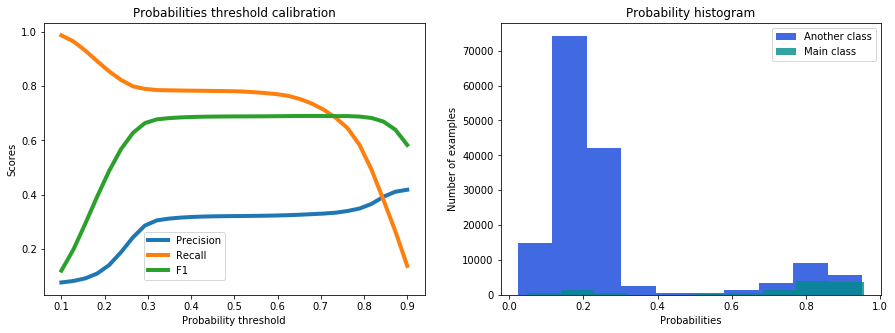

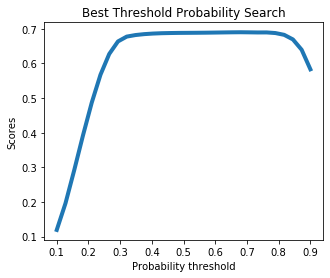

best threshold probability = 0.6793103448275862
report after calibration
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93    154214
         1.0       0.33      0.74      0.45     12117

    accuracy                           0.87    166331
   macro avg       0.65      0.81      0.69    166331
weighted avg       0.93      0.87      0.89    166331

f1 score before calibration 0.6880920917946789
f1 score after calibration 0.6900178008154743


In [108]:
lg_estimator = lgb.LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [3],
    'n_estimators': [120],
    'min_child_weight': [0.001],
    'reg_lambda': [0],
    'reg_alpha': [0],
    'num_leaves': [10]
    }

lg_gs = SingleModel(estimator=lg_estimator, model_label='lgboost', param_grid=param_grid, cv=cv_3)

lg_gs.run_grid_search(X_train_gs=X_train_gs, y_train_gs=y_train_gs)

lg_gs.test_best_model_on_valid_set(X_train_gs, y_train_gs, X_valid, y_valid)

lg_gs.add_gs_results(gs_results)

In [109]:
save_gs_results()

LGBM - не позволяет достичь более высокого показателя, чем алгоритм Логистической регрессии

#### Финальное сравнение и выбор алгоритма

In [122]:
results_df = pd.DataFrame(gs_results).T
results_df

,f1_macro,best_params,probability
logreg,0.691045,"{'C': 0.0001, 'class_weight': 'balanced', 'dua...",0.734483
bayes,0.691313,"{'priors': None, 'var_smoothing': 1}",0.568966
random_forest,0.691608,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.706897
xgboost,0.684758,"{'base_score': 0.5, 'booster': 'gblinear', 'co...",0.513793
lgboost,0.690018,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",0.67931


- наилучшие результаты показал алгоритм случайного леса
- вместе с тем разница значений метрик у всех методов минимальна
- также отмечается слабое влияние гиперпараметров и калибровки вероятностей на результаты метрики

- таким образом для финальной модели будет выбран алгоритм Случайного Леса и соответствующая калибровочная вероятность

### Обучение финальной модели

In [131]:
# 5.1. Инициализация параметров
gs_results = load_gs_results()
final_model = RandomForestClassifier(**gs_results['random_forest']['best_params'])
threshold_prob = gs_results['random_forest']['probability']

# 5.2. Инициализация пайплайна
final_pipe_steps = [
                    ('scaler', MinMaxScaler()),
                    ('pca', PCA(n_components=45)),
                    ('oversampler', smote),
                    ('rf', final_model)
]

final_pipe = SM_Pipeline(final_pipe_steps, verbose=True)

# 5.3. Обучение модели
final_pipe.fit(X_train_wcat, y_train)
predict_train = final_pipe.predict(X_train_wcat)
print(classification_report(y_train, predict_train))

[Pipeline] ............ (step 1 of 4) Processing scaler, total=   3.7s
[Pipeline] ............... (step 2 of 4) Processing pca, total=  15.5s
[Pipeline] ....... (step 3 of 4) Processing oversampler, total=  33.3s
[Pipeline] ................ (step 4 of 4) Processing rf, total= 3.9min
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    771467
         1.0       0.32      0.77      0.46     60186

    accuracy                           0.87    831653
   macro avg       0.65      0.82      0.69    831653
weighted avg       0.93      0.87      0.89    831653



In [138]:
# 5.4. Сохранение модели в формате pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(final_pipe, f)

### Генерация прогноза по ТЕСТОВОЙ выборке

In [139]:
# 6.1. Загрузка сырых данных
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')
data_feat = pd.read_csv('../feat_data/features.csv', encoding='utf-8', sep='\t') # файл - вне GIT папки

In [140]:
# 6.2. Преобразование сырых данных
X_test = create_X_y(data_test, data_feat)
data_feat = None

In [141]:
# 6.3. Преобразование категориальных признаков
X_test = cat_encoder.transform(X_test)

categorical dummy-cols with zeroes: ['31_12.709274745774431', '27_148.5082668650477', '154_249.99991667641729', '31_7.8292747457744305', '198_0.4994326905007571', '27_160.6582668650477', '31_76.25927474577443', '95_6.359885410129311', '202_27.99995634376119', '27_21.648266865047702', '31_50.83927474577443', '197_3.999959667840288', '194_0.4983443870043576', '197_7.999959667840288', '27_19.578266865047702', '95_12.709885410129313', '31_37.70927474577443', '154_1.9999166764172984', '27_889.8582668650478', '27_74.15326686504768', '202_1.9999563437611911', '95_61.45988541012931', '31_3.1192747457744314', '197_0.9999596678402882', '197_1.4999596678402882', '31_88.96927474577444', '27_149.48826686504768', '202_0.9999563437611908', '15_0.4999696400775796', '31_25.41927474577443', '206_0.49997695305159323', '154_44.99991667641729', '27_325.2682668650477', '197_1.999959667840288', '197_2.9999596678402884', '31_38.12927474577443', '154_0.9999166764172986', '202_2.999956343761192']
new (ignored a

In [142]:
# 6.4. Загрузка обученной модели
with open('model.pkl', 'rb') as f:
    pipe_model = pickle.load(f)

In [144]:
# 6.5. Генерация прогноза вероятностей
test_predict_probas = pipe_model.predict_proba(X_test)

In [148]:
# 6.6. Генерация прогноза классов с учетом калибровки
with open('gs_results.pkl', 'rb') as f:
    table = pickle.load(f)

threshold = table['random_forest']['probability']

test_predict_class = np.array([1 if x>=threshold else 0 for x in test_predict_probas[:,1]])

In [157]:
# 6.7. Подготовка итоговых данных
data_test_predict = data_test.copy()
data_test_predict = data_test_predict.drop(columns=['Unnamed: 0'], axis=1)
data_test_predict['predict'] = test_predict_class

data_test_predict.head()

,id,vas_id,buy_time,predict
0,3130519,2.0,1548018000,0
1,2000860,4.0,1548018000,1
2,1099444,2.0,1546808400,0
3,1343255,5.0,1547413200,0
4,1277040,2.0,1546808400,0


In [158]:
# 6.8. Экспорт данных в CSV
file_name = 'answers_test.csv'
data_test_predict.to_csv(file_name)